# Word2vec only with one matrix

Choose CBOW/Skip-Gram again. Implement it, but now without second `h_dim x vocab_size` matrix. Remember what was the loss function in Stanford lecture.

$$ L = - \frac{1}{T} \sum_{t=1}^T \sum_{-m <= j <= m, j \ne 0} log P(w_{t+j}|w_{t+j-m})$$


$$ P(w_h | w_i) = \frac{exp(s(v_i, v_h))}{\sum exp(s(v_i, v_w))}$$

Where $s(x, y)$ is a similarity function. It is common to use dot-product here $s(x, y) = s^Ty$. The sum in the denominator is across all vocabulary for $P$ to be a probability distribution.

Look to this formula closer. There is no projection back to vocabulary dimension in the loss! So, we can reduce the number of parameters by the factor of two by not using the second matrix $W'$. Your new task is to code CBOW / SkipGram with this loss.

**Main idea:**

We project word vectors to some space. Next, we work with the space itself. We update projection matrix weights so that similar (in the terms of Distributional semantics) words have similar vectors in that space. We don't need to solve classification task explicitly here.

**Tip:**

Work with matrix operations and not with nn.layers / keras.layers.

**Results of this task** (the very same as in task 3):
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies


**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)



Supplementary materials:
  * [cs224n winter 2017 lecture 2 video](https://www.youtube.com/watch?v=ERibwqs9p38&list=PL3FW7Lu3i5Jsnh1rnUwq_TcylNr7EkRe6&index=2)
  * [cs224n winter 2019 lecture 1 slides](http://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture01-wordvecs1.pdf)

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
from torch import optim
from torch.nn.init import kaiming_normal_

In [3]:
from part1 import plot_embeddings

In [4]:
from part2 import process_corpus, build_vocab, CBOWBatcher

In [22]:
from part3 import get_encode_emb

In [5]:
from part4 import CBOW_one_matrix

In [6]:
batcher = CBOWBatcher(batch_size=128, window_size=5, shuffle=True)

In [7]:
corpus = process_corpus('text8')

In [8]:
vocab = build_vocab(corpus, min_freq=5)

In [9]:
batcher.init(corpus, vocab)

## Training loop

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [11]:
model = CBOW_one_matrix(vocab_size=len(vocab), hidden_size=300, device=device)

In [12]:
optimizer = optim.SGD(params=model.parameters(),
                      lr=1e-2, momentum=0.9, weight_decay=1e-6)

In [13]:
CE_loss = nn.CrossEntropyLoss()

In [14]:
losses = []
for epoch in range(30):
    for i, (x, y) in tqdm(enumerate(batcher)):
        x_torch = torch.LongTensor(x).to(device)
        y_torch = torch.LongTensor(y).to(device)
        
        activations = model(x_torch)
        loss = CE_loss(activations, y_torch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(float(loss.cpu().data.numpy()))
        if (i + 1) % 10000 == 0:
            print(np.mean(losses[-10000:]))

10018it [01:40, 100.63it/s]

7.323787978553772


20017it [03:19, 100.49it/s]

6.796564934062958


30016it [04:58, 100.78it/s]

6.587090650892257


40015it [06:37, 100.59it/s]

6.451737609863281


50014it [08:17, 100.46it/s]

6.386333142375946


60013it [09:56, 100.61it/s]

6.322166442918777


80011it [13:14, 100.43it/s]

6.256414562511444


90016it [14:54, 100.56it/s]

6.219307860708237


100015it [16:33, 100.53it/s]

6.208196391773224


104701it [17:19, 100.67it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

70016it [11:35, 100.56it/s]

6.087062516593933


80015it [13:14, 100.59it/s]

6.081265620422363


90014it [14:54, 100.54it/s]

6.066199436712265


95349it [15:47, 100.72it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

60017it [09:56, 100.45it/s]

6.027674404335022


70016it [11:35, 100.58it/s]

6.024823533391952


80015it [13:15, 100.53it/s]

6.013309039926529


83348it [13:48, 100.89it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

40018it [06:38, 100.59it/s]

5.9865939629554745


50017it [08:17, 100.61it/s]

5.9865534435749055


60016it [09:56, 100.52it/s]

5.9827552557468415


63019it [10:26, 100.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

20010it [03:19, 100.25it/s]

5.9504458548069


30020it [04:59, 100.41it/s]

5.950450569105148


40019it [06:38, 100.63it/s]

5.94611313123703


50018it [08:17, 100.33it/s]

5.9453980809688565


50502it [08:22, 100.71it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

132873it [22:00, 100.62it/s]
10011it [01:40, 100.50it/s]

5.926531767892837


20010it [03:19, 100.42it/s]

5.915893394041062


30020it [04:59, 100.47it/s]

5.917127075815201


32110it [05:19, 100.70it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

120011it [19:52, 100.53it/s]

5.898116883039474


124444it [20:36, 100.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

10011it [01:40, 100.48it/s]

5.889846220874786


19603it [03:15, 100.61it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100013it [16:34, 100.46it/s]

5.880574603414535


110012it [18:13, 100.47it/s]

5.874512754917145


111079it [18:24, 100.68it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

130010it [21:32, 100.44it/s]

5.871845334434509


132873it [22:01, 100.58it/s]
6645it [01:06, 100.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

90014it [14:55, 100.47it/s]

5.853106180524826


97373it [16:08, 100.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

110012it [18:13, 100.51it/s]

5.848271618318558


120011it [19:52, 100.40it/s]

5.843963623476029


125874it [20:51, 100.57it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

80014it [13:15, 100.68it/s]

5.8289847688674925


90013it [14:54, 100.62it/s]

5.8334040652275085


100012it [16:33, 100.50it/s]

5.829085360002518


103411it [17:07, 100.74it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

50018it [08:17, 100.55it/s]

5.816517260122299


57707it [09:33, 100.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

70016it [11:35, 100.54it/s]

5.819171389245987


80015it [13:15, 100.45it/s]

5.808679404497147


90014it [14:54, 100.68it/s]

5.8106540825843815


90729it [15:01, 100.77it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

40019it [06:38, 100.81it/s]

5.79566680984497


44276it [07:20, 100.75it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

60017it [09:57, 100.86it/s]

5.791983004570008


70016it [11:36, 100.84it/s]

5.79288536605835


76858it [12:44, 100.66it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

20010it [03:19, 100.45it/s]

5.7817930538654325


30020it [04:58, 100.57it/s]

5.780856217050553


30779it [05:06, 100.67it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

50018it [08:17, 100.54it/s]

5.780312825107575


60017it [09:56, 100.59it/s]

5.774028195667267


63449it [10:30, 100.92it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

10011it [01:40, 100.48it/s]

5.766336707973481


16908it [02:48, 100.56it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

30020it [04:59, 100.52it/s]

5.759155176591873


40019it [06:38, 100.53it/s]

5.768730650949478


49248it [08:10, 100.66it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

130010it [21:32, 100.43it/s]

5.748480232048035


132873it [22:00, 100.59it/s]
10011it [01:40, 100.44it/s]

5.748218626737595


20010it [03:19, 100.35it/s]

5.748505047655105


26082it [04:20, 100.73it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100013it [16:34, 100.56it/s]

5.731804737472534


108296it [17:56, 100.74it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

130010it [21:32, 100.28it/s]

5.736460879611969


132873it [22:00, 100.59it/s]
10011it [01:40, 100.29it/s]

5.73107681684494


13168it [02:11, 100.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

90011it [14:55, 100.53it/s]

5.719524452590942


94961it [15:44, 100.66it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

110020it [18:13, 100.57it/s]

5.728432092761993


120019it [19:53, 100.43it/s]

5.718988433170319


130018it [21:32, 100.55it/s]

5.725595181226731


132680it [21:58, 100.70it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

80014it [13:15, 100.28it/s]

5.718762705230713


81741it [13:33, 100.48it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100013it [16:35, 100.35it/s]

5.711947315168381


110012it [18:14, 100.31it/s]

5.711665353012085


119263it [19:46, 100.44it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

60014it [09:58, 100.54it/s]

5.704850027036667


67549it [11:12, 100.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

90011it [14:56, 100.27it/s]

5.6977348890781405


100010it [16:36, 100.26it/s]

5.70502036895752


106236it [17:38, 100.46it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

50018it [08:18, 100.35it/s]

5.698042856025696


54902it [09:07, 100.63it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

70015it [11:37, 100.13it/s]

5.687324831104279


80010it [13:17, 100.17it/s]

5.686969866991043


90020it [14:56, 100.36it/s]

5.693409101104736


93386it [15:30, 100.56it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

40019it [06:39, 100.31it/s]

5.693992177629471


41746it [06:56, 100.47it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

60017it [09:58, 100.25it/s]

5.674040591573715


70016it [11:37, 100.37it/s]

5.682185336828232


79960it [13:16, 100.50it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

90014it [14:56, 100.14it/s]

5.683132724142075


100011it [16:36, 100.08it/s]

5.673635899209976


110010it [18:15, 100.20it/s]

5.674902307939529


120020it [19:55, 100.24it/s]

5.667514586257934


130019it [21:35, 100.27it/s]

5.673895795917511


132873it [22:03, 100.40it/s]
10011it [01:40, 100.34it/s]

5.673621640586853


20020it [03:20, 100.18it/s]

5.677794884109497


30019it [04:59, 100.23it/s]

5.671400763130188


40018it [06:39, 100.37it/s]

5.675081904983521


50010it [08:18, 100.45it/s]

5.664005839157104


60020it [09:58, 100.52it/s]

5.674266651821137


70019it [11:37, 100.44it/s]

5.6694458471775055


80018it [13:16, 100.33it/s]

5.669698407506942


90017it [14:56, 100.26it/s]

5.662013827562332


100016it [16:35, 100.40it/s]

5.667526069068908


110019it [18:15, 100.37it/s]

5.663345989656448


120018it [19:54, 100.58it/s]

5.660434545040131


130017it [21:33, 100.50it/s]

5.663957008695602


132873it [22:02, 100.48it/s]
10010it [01:40, 100.07it/s]

5.662500520563126


20020it [03:20, 100.33it/s]

5.6595632477283475


30019it [04:59, 100.21it/s]

5.666371779346466


40012it [06:39, 100.30it/s]

5.668167249631882


50011it [08:18, 100.22it/s]

5.664189317131043


60010it [09:58, 100.11it/s]

5.660066014385223


70020it [11:38, 100.17it/s]

5.655209894657135


80019it [13:17, 100.43it/s]

5.652752511548996


90018it [14:57, 100.58it/s]

5.656791917037964


100015it [16:36, 100.31it/s]

5.651359550285339


110014it [18:16, 100.51it/s]

5.6515669942855835


120013it [19:55, 100.61it/s]

5.653879661607743


130011it [21:34, 100.15it/s]

5.653677886724472


132873it [22:03, 100.40it/s]
10011it [01:40, 100.48it/s]

5.645799513483047


20010it [03:19, 100.20it/s]

5.647767086791992


30020it [04:59, 100.32it/s]

5.648261597061158


40019it [06:38, 100.35it/s]

5.653800115251541


50018it [08:18, 100.60it/s]

5.64933937830925


60017it [09:57, 100.29it/s]

5.651028374624253


70016it [11:37, 100.49it/s]

5.649345345497132


80015it [13:16, 100.33it/s]

5.648134110975265


90014it [14:56, 100.52it/s]

5.645569329118729


100013it [16:35, 100.46it/s]

5.643556640625


110012it [18:15, 100.34it/s]

5.649912433385849


120011it [19:54, 100.29it/s]

5.649488915395737


130010it [21:34, 100.25it/s]

5.651444598674774


132873it [22:02, 100.45it/s]
10011it [01:40, 100.30it/s]

5.644530473232269


20010it [03:20, 100.05it/s]

5.6461636033535


30020it [04:59, 100.31it/s]

5.639929312181473


40018it [06:39, 100.22it/s]

5.638151559829712


50017it [08:18, 100.32it/s]

5.639077270030976


60020it [09:58, 100.30it/s]

5.637525830125809


70012it [11:37, 100.32it/s]

5.643229812240601


80011it [13:17, 100.31it/s]

5.643373426389695


90010it [14:56, 100.46it/s]

5.636205994415283


100020it [16:36, 100.28it/s]

5.640382506895065


110019it [18:15, 100.28it/s]

5.633230813264847


120018it [19:55, 100.34it/s]

5.637275801038742


130017it [21:34, 100.28it/s]

5.630571480989456


132873it [22:03, 100.42it/s]
10011it [01:40, 100.27it/s]

5.63237621011734


20010it [03:20, 100.23it/s]

5.633024444723129


30020it [04:59, 100.26it/s]

5.632124541330337


40019it [06:39, 100.20it/s]

5.6349915060520175


50018it [08:18, 100.27it/s]

5.636615145158768


60017it [09:58, 100.31it/s]

5.62965634522438


70016it [11:37, 100.47it/s]

5.625896379041672


80015it [13:17, 100.30it/s]

5.626022433185577


90014it [14:56, 100.29it/s]

5.634068005084991


100013it [16:36, 100.28it/s]

5.63483613114357


110012it [18:15, 100.35it/s]

5.624099765300751


120011it [19:55, 100.28it/s]

5.623583609247207


130010it [21:34, 100.23it/s]

5.625049726390839


132873it [22:03, 100.42it/s]
10011it [01:40, 100.37it/s]

5.624726156568527


20010it [03:20, 100.35it/s]

5.625032957482338


30020it [04:59, 100.03it/s]

5.622047633075714


40019it [06:39, 100.29it/s]

5.633423304891586


50018it [08:18, 100.50it/s]

5.623010214567184


60017it [09:58, 100.29it/s]

5.62000085067749


70016it [11:37, 100.35it/s]

5.617874703502655


80013it [13:17, 100.33it/s]

5.623790875482559


90012it [14:56, 100.14it/s]

5.621288958215714


100011it [16:36, 100.26it/s]

5.619256998682022


110010it [18:15, 100.07it/s]

5.622056057024002


120020it [19:55, 100.19it/s]

5.619647335720062


130019it [21:34, 100.38it/s]

5.612990117120742


132873it [22:03, 100.41it/s]
10019it [01:40, 100.18it/s]

5.619641370058059


20018it [03:20, 100.19it/s]

5.619631991910935


30017it [04:59, 100.17it/s]

5.609378216171264


40014it [06:39, 100.07it/s]

5.6152210875988


50013it [08:18, 100.33it/s]

5.61600999121666


60012it [09:58, 100.34it/s]

5.610721753644944


70011it [11:38, 100.29it/s]

5.61615690073967


80010it [13:17, 100.23it/s]

5.608837130117417


90020it [14:57, 100.21it/s]

5.610626231861114


100015it [16:36, 100.38it/s]

5.608990983438492


110014it [18:16, 100.39it/s]

5.610406431055069


120013it [19:55, 100.38it/s]

5.617432942152023


130012it [21:35, 100.28it/s]

5.609459918832779


132873it [22:03, 100.39it/s]
10011it [01:40, 100.20it/s]

5.608142137384415


20020it [03:20, 100.01it/s]

5.611962971591949


30019it [04:59, 100.21it/s]

5.61120404624939


40018it [06:39, 100.34it/s]

5.603798350143433


50011it [08:18, 100.27it/s]

5.6084316815376285


60010it [09:58, 100.20it/s]

5.604280328607559


70020it [11:38, 100.29it/s]

5.6098611792564395


80019it [13:17, 100.56it/s]

5.59968207859993


90018it [14:57, 100.30it/s]

5.605667515230179


100017it [16:36, 100.27it/s]

5.5997361557006835


106738it [17:43, 100.46it/s]

KeyboardInterrupt: 

## График скользящего среднего loss'a. 
## Видно, что сходится, но плато не достигается(дольше тренировать нету возможности)

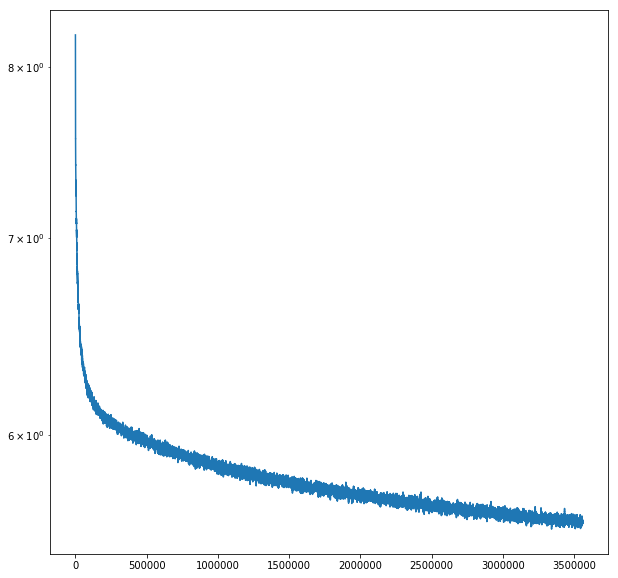

106738it [18:00, 100.46it/s]

In [15]:
m = np.convolve(losses, np.ones(1000) / 1000)
plt.figure(figsize=(10, 10))
plt.plot(m[1000:-1000])
plt.yscale('log')
plt.show()

## Выбираем частые слова для визуализации

In [16]:
from collections import Counter
c = Counter()
for sent in corpus:
    c.update(sent)

In [17]:
words = sorted(c.keys(), key=lambda item: c[item], reverse=True)[:10000]
words = np.random.choice(words, 300, replace=False)

In [18]:
words

array(['gave', 'namely', 'wasn', 'than', 'archaeology', 'reduce',
       'conditions', 'satellites', 'mile', 'definitions', 'mid',
       'imports', 'progress', 'warfare', 'verbal', 'pseudonym', 'when',
       'venezuela', 'ruling', 'object', 'overthrown', 'esperanto',
       'stake', 'intense', 'rousseau', 'absent', 'metallica', 'tubes',
       'sign', 'mishnah', 'electorate', 'incest', 'francisco', 'laid',
       'exchanged', 'per', 'geneva', 'flora', 'gel', 'submitted', 'warm',
       'taxes', 'boiling', 'what', 'darker', 'substrate', 'western',
       'illness', 'be', 'grown', 'exercised', 'advisor', 'reported',
       'infant', 'applies', 'epistle', 'pointed', 'segments', 'court',
       'autonomy', 'invasions', 'debates', 'carey', 'mount', 'autism',
       'equally', 'maintained', 'estimate', 'enemies', 'bassist', 'cm',
       'factions', 'kabul', 'which', 'infrastructure', 'vii', 'bremen',
       'operate', 'named', 'fr', 'italian', 'heavier', 'equivalent',
       'massachusetts

In [23]:
v = get_encode_emb(words, model, batcher, device)

In [24]:
from sklearn.manifold import TSNE
X = TSNE(n_components=2).fit_transform(v)

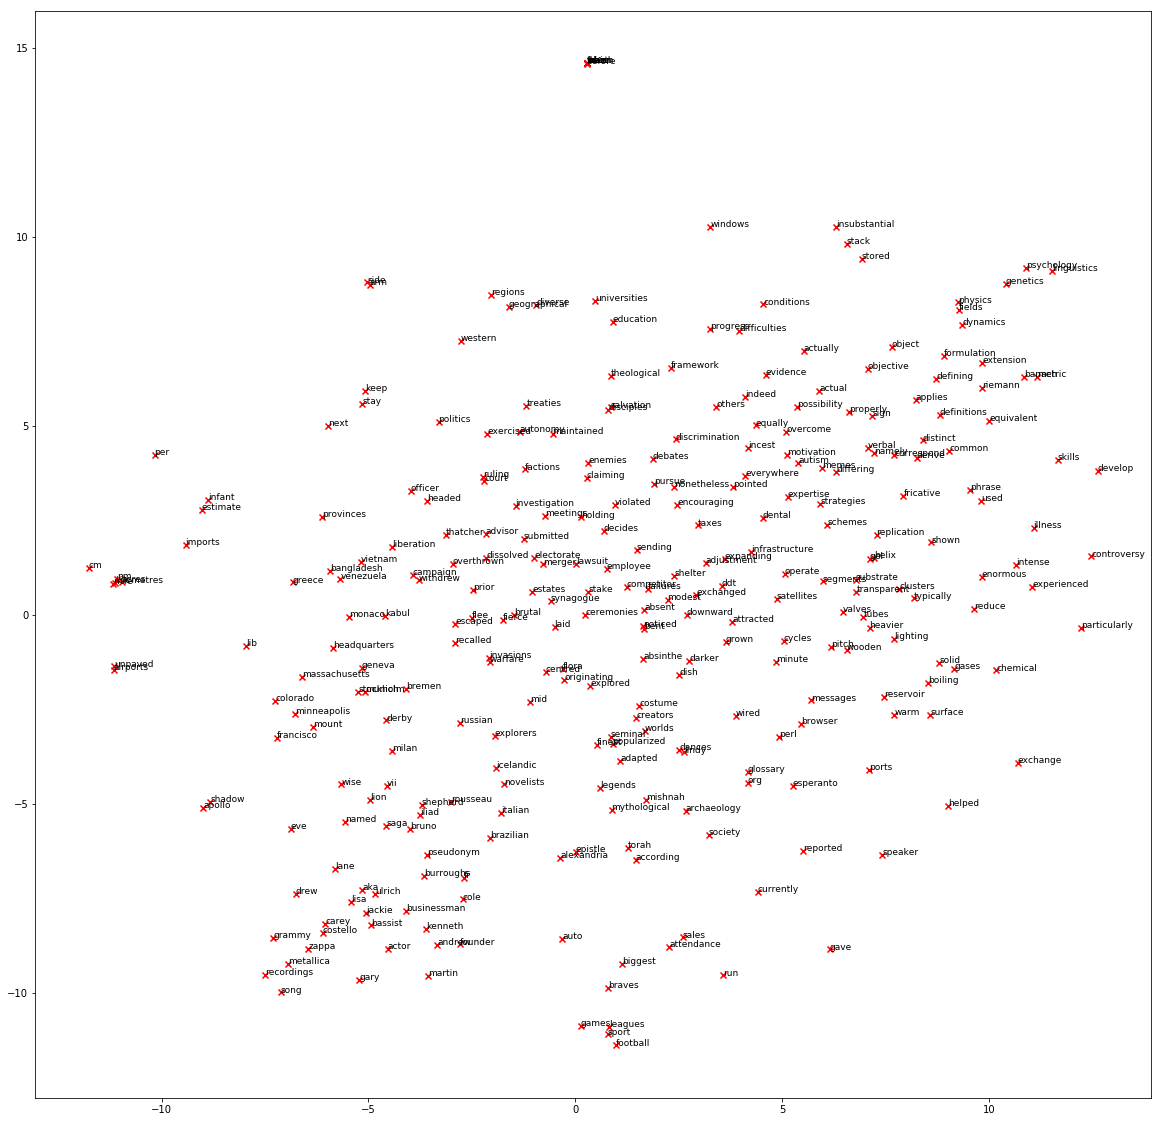

In [25]:
plot_embeddings(X, batcher.word2ind, words)

## T-SNE проекция получается осмысленной, с ближайшими соседями хуже

In [26]:
from part3 import Index

In [27]:
%%time
idx = Index(model, vocab, batcher, get_encode_emb, device)

CPU times: user 7.29 s, sys: 195 ms, total: 7.49 s
Wall time: 7.49 s


In [28]:
idx.most_similar(['teen'], k=20)

[('teen', 0.0),
 ('muppet', 0.7255322114299183),
 ('trivia', 0.7415080122254372),
 ('appearing', 0.7458594788243289),
 ('sitcom', 0.7732851282940906),
 ('brooks', 0.7784082992387681),
 ('favorite', 0.7814683227659931),
 ('carey', 0.7821676205872363),
 ('lois', 0.7829561676555196),
 ('crosby', 0.7871297071684787),
 ('frankie', 0.7889013597983199),
 ('spears', 0.7890681653716403),
 ('acclaimed', 0.7898278254593095),
 ('filmed', 0.794169789541962),
 ('parody', 0.7965237460431165),
 ('syndicated', 0.7966724961225824),
 ('kid', 0.7974853795902768),
 ('dubbed', 0.7977139787398636),
 ('guest', 0.7978913800355422),
 ('cartoon', 0.7983785170774335)]

In [29]:
idx.most_similar(['man'], k=20)

[('man', 0.0),
 ('spider', 0.6134965846581438),
 ('woman', 0.6826546458170687),
 ('isle', 0.6874171553895307),
 ('young', 0.8078856754179026),
 ('wise', 0.8138908073379537),
 ('girl', 0.8440900753054659),
 ('creature', 0.8709286931102144),
 ('beautiful', 0.8729832431893548),
 ('god', 0.8950624512882245),
 ('invisible', 0.895085392186877),
 ('devil', 0.897410792962046),
 ('strange', 0.8984050910743463),
 ('baby', 0.9025920839962942),
 ('angry', 0.9049709436062104),
 ('amazing', 0.9055597373135152),
 ('dream', 0.9083972354307651),
 ('tells', 0.9087463723048615),
 ('eyes', 0.9102940270919486),
 ('wonder', 0.9104475611166598)]

In [30]:
idx.most_similar(pos=['woman', 'king'], neg=['man'], k=20)

[('king', 0.6334093834574934),
 ('crowned', 0.7890655970748703),
 ('afonso', 0.7930471823102385),
 ('castile', 0.8041039730663179),
 ('vii', 0.8048912457045387),
 ('alfonso', 0.8341546699989997),
 ('aragon', 0.8368464011903144),
 ('viii', 0.8389194103678732),
 ('sons', 0.8560982743763518),
 ('philip', 0.8577284210634969),
 ('daughter', 0.8583436846494711),
 ('iv', 0.860563739155959),
 ('succeeded', 0.861068375015789),
 ('eldest', 0.8658100908064569),
 ('illegitimate', 0.8700643709638193),
 ('reigned', 0.8727585830725368),
 ('bohemia', 0.8772487694271541),
 ('vi', 0.8777942659107763),
 ('heir', 0.8824875495183666),
 ('cousin', 0.8827582823722135)]

In [31]:
idx.most_similar(pos=['usa', 'london'], neg=['england'], k=20)

[('usa', 0.8237642598980093),
 ('london', 0.8904715958037908),
 ('underground', 0.9185588482116258),
 ('toronto', 0.9300565227641779),
 ('ltd', 0.9356295682480874),
 ('metro', 0.9536678144309604),
 ('routledge', 0.9543347732569946),
 ('opened', 0.9551266460926223),
 ('helsinki', 0.957040498649906),
 ('tokyo', 0.9586101042480202),
 ('publishing', 0.9611856403805368),
 ('manhattan', 0.9817817073526752),
 ('tower', 0.9876645240865592),
 ('ny', 0.9884124789356036),
 ('oklahoma', 0.9914750372167626),
 ('gallery', 0.9916055429411412),
 ('railway', 0.9917022840263743),
 ('denver', 0.9960296909453042),
 ('philadelphia', 0.9963832060667769),
 ('chrysler', 0.996536665037595)]